# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [74]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [75]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = filtered_data['Score'].map(partition)
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [76]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [77]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [78]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [79]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [80]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [81]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [82]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [83]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [84]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [85]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [87]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [88]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [89]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [90]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [91]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [92]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [93]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [94]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [95]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [96]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:40<00:00, 2177.43it/s]


In [97]:
preprocessed_reviews[0]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [98]:
## Similartly you can do preprocessing for review summary also.


# Data Split

In [99]:
from sklearn.model_selection import train_test_split

final['Text'] = preprocessed_reviews

X = final['Text'].values
Y = final['Score'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.3)

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [100]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("After vectorizations")
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaand', 'aaah']
After vectorizations
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 38974)
the number of unique words  38974


## [4.3] TF-IDF

In [101]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able find', 'able finish']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 25558)
the number of unique words including both unigrams and bigrams  25558


## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V

In [105]:
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=2)

w2v_words = list(w2v_model.wv.vocab)

In [103]:
def avgw2v(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [104]:
sent_vectors_train = avgw2v(list_of_sentance_train)
print(len(sent_vectors_train[0]))
print(len(list_of_sentance_train))

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:21<00:00, 529.71it/s]


50
43008


In [106]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

sent_vectors_cv = avgw2v(list_of_sentance_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:35<00:00, 515.25it/s]


18433
50


In [107]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = avgw2v(list_of_sentance_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:50<00:00, 517.76it/s]


26332
50


#### [4.4.1.2] TFIDF weighted W2v

In [108]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [109]:
# TF-IDF weighted Word2Vec
def tfidfw2v(list_of_sentance):
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [110]:
tfidf_sent_vectors_train = tfidfw2v(list_of_sentance_train)

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [12:58<00:00, 55.26it/s]


In [111]:
tfidf_sent_vectors_cv = tfidfw2v(list_of_sentance_cv)

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [05:28<00:00, 56.07it/s]


In [112]:
tfidf_sent_vectors_test = tfidfw2v(list_of_sentance_test)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [07:50<00:00, 55.99it/s]


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

# 1: Hyper parameter Tuning

In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [114]:
def KNN_brute(X_train_vector, Y_train, X_cv_vector, Y_cv):  
    myList = list(range(0,51))
    neighbors = list(filter(lambda x: x%2 !=0, myList))
    train_auc = []
    cv_auc = []

    y_train_pred = []
    y_cv_pred = []

    for i in neighbors :
        knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
        knn.fit(X_train_vector, Y_train)
        y_train_pred = knn.predict_proba(X_train_vector)[:,1]
        y_cv_pred = knn.predict_proba(X_cv_vector)[:,1]

        train_auc.append(roc_auc_score(Y_train, y_train_pred))
        cv_auc.append(roc_auc_score(Y_cv, y_cv_pred))

    plt.plot(neighbors, train_auc, label ='Train AUC')
    plt.plot(neighbors, cv_auc, label="CV AUC")
    plt.legend()
    plt.xlabel("K: Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error plots")
    plt.show()

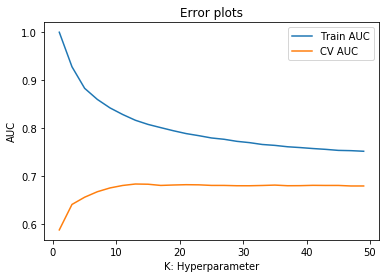

In [115]:
KNN_brute(X_train_bow, Y_train, X_cv_bow, Y_cv)

# 2: Testing with test data

In [116]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [117]:
def KNN_Test(X_train_vector, Y_train, X_test_vector, Y_test, bestK):
    best_k=bestK
    neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
    neigh.fit(X_train_vector, Y_train)

    train_FPR, train_TPR, thresholds = roc_curve(Y_train, neigh.predict_proba(X_train_vector)[:,1])
    test_FPR, test_TPR, thresholds = roc_curve(Y_test, neigh.predict_proba(X_test_vector)[:,1])

    test_auc = auc(test_FPR, test_TPR)
    plt.plot(train_FPR, train_TPR, label="Train AUC="+str(auc(train_FPR, train_TPR)))
    plt.plot(test_FPR, test_TPR, label="Test AUC="+str(test_auc))

    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    from sklearn.metrics import confusion_matrix
    print("Train confusion metric")
    print(confusion_matrix(Y_train, neigh.predict(X_train_vector)))
        
    print("Testing confusion metric")
    cm = confusion_matrix(Y_test, neigh.predict(X_test_vector))
    print(cm)
       
    # plot confusion matrix to describe the performance of classifier.
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()  
    
    return test_auc   

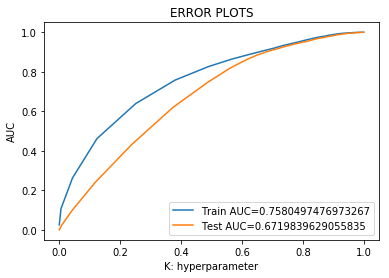

Train confusion metric
[[  781  6119]
 [  541 35567]]
Testing confusion metric
[[  436  3909]
 [  382 21605]]


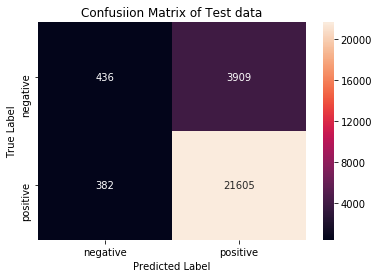

In [118]:
auc_brute_bow = KNN_Test(X_train_bow, Y_train, X_test_bow, Y_test, bestK=40)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

# 1: Hyper parameter Tuning

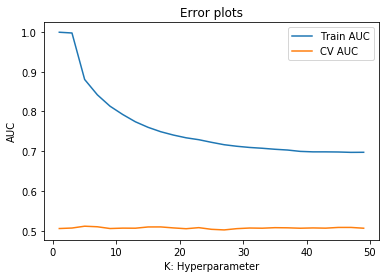

In [119]:
KNN_brute(X_train_tfidf, Y_train, X_cv_tfidf, Y_cv)

# 2: Testing with test data

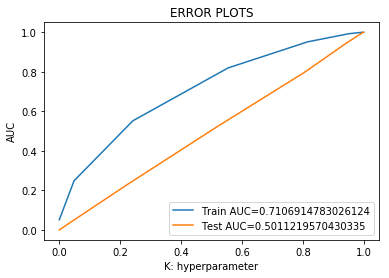

Train confusion metric
[[    0  6900]
 [    0 36108]]
Testing confusion metric
[[    0  4345]
 [    0 21987]]


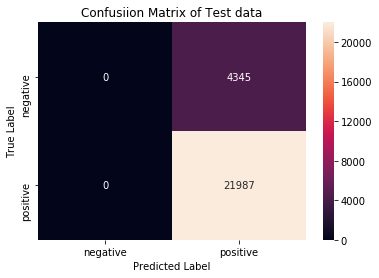

In [120]:
auc_brute_tfidf = KNN_Test(X_train_tfidf, Y_train, X_test_tfidf, Y_test, bestK=30)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

# 1: Hyper parameter Tuning

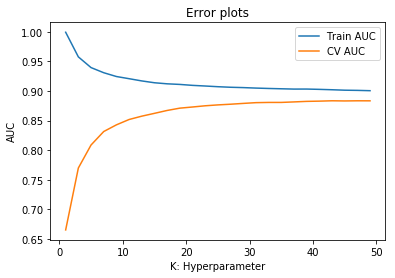

In [121]:
KNN_brute(sent_vectors_train, Y_train, sent_vectors_cv, Y_cv)

# 2: Testing with test data

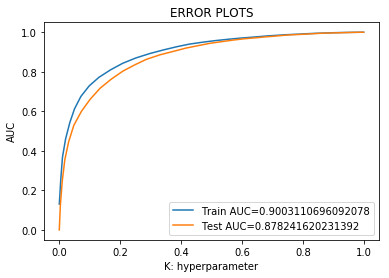

Train confusion metric
[[ 1794  5106]
 [  466 35642]]
Testing confusion metric
[[ 1051  3294]
 [  292 21695]]


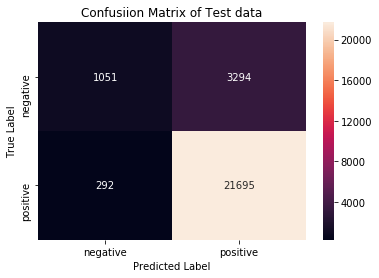

In [122]:
auc_brute_avgw2v = KNN_Test(sent_vectors_train, Y_train, sent_vectors_test, Y_test, bestK=50)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

# 1: Hyper parameter Tuning

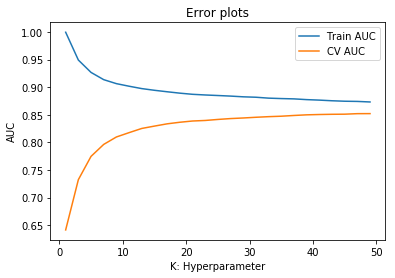

In [123]:
KNN_brute(tfidf_sent_vectors_train, Y_train, tfidf_sent_vectors_cv, Y_cv)

# 2: Testing with test data

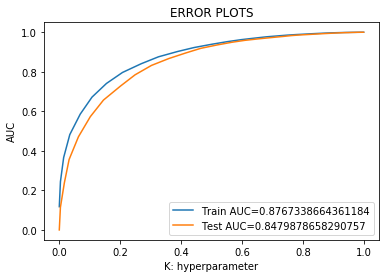

Train confusion metric
[[ 1536  5364]
 [  429 35679]]
Testing confusion metric
[[  889  3456]
 [  292 21695]]


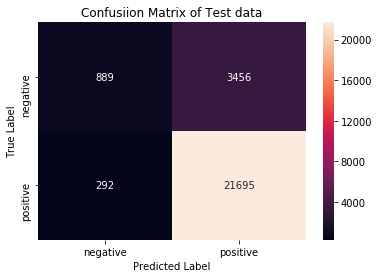

In [124]:
auc_brute_tfidfw2v = KNN_Test(tfidf_sent_vectors_train, Y_train, tfidf_sent_vectors_test, Y_test, bestK=40)

## [5.2] Applying KNN kd-tree

##### Selecting only 40K records for KD Tree

In [125]:
kdtree_data = final.sample(n=40000, random_state=1)
print(kdtree_data.shape)

(40000, 10)


In [126]:
# Spliting the data for KD Tree
X_kd = kdtree_data['Text'].values
Y_kd = kdtree_data['Score'].values

X_train_kd, X_test_kd, Y_train_kd, Y_test_kd = train_test_split(X_kd, Y_kd, test_size=0.3)
X_train_kd, X_cv_kd, Y_train_kd, Y_cv_kd = train_test_split(X_train_kd, Y_train_kd, test_size=0.3)

print(X_train_kd.shape, Y_train_kd.shape)
print(X_cv_kd.shape, Y_cv_kd.shape)
print(X_test_kd.shape, Y_test_kd.shape)

(19600,) (19600,)
(8400,) (8400,)
(12000,) (12000,)


##### BoW with 500 features

In [127]:
count_vect_kd = CountVectorizer(min_df=10, max_features=500)
count_vect_kd.fit(X_train_kd)

X_train_bow_kd = count_vect_kd.transform(X_train_kd)
X_cv_bow_kd = count_vect_kd.transform(X_cv_kd)
X_test_bow_kd = count_vect_kd.transform(X_test_kd)

#### TFIDF with 500 features

In [128]:
tf_idf_vect_kd = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect_kd.fit(X_train_kd)

X_train_tfidf_kd = tf_idf_vect_kd.transform(X_train_kd)
X_cv_tfidf_kd = tf_idf_vect_kd.transform(X_cv_kd)
X_test_tfidf_kd = tf_idf_vect_kd.transform(X_test_kd)

In [129]:
#W2V
def avgw2v_Kdtree(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words_kd:
                vec = w2v_model_kd.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [130]:
list_of_sentance_train_kd=[]
for sentance in X_train_kd:
    list_of_sentance_train_kd.append(sentance.split())

w2v_model_kd=Word2Vec(list_of_sentance_train_kd,min_count=5,size=50, workers=2)

w2v_words_kd = list(w2v_model_kd.wv.vocab)

sent_vectors_train_kd = avgw2v_Kdtree(list_of_sentance_train_kd)

100%|███████████████████████████████████████████████████████████████████████████| 19600/19600 [00:30<00:00, 642.95it/s]


In [131]:
list_of_sentance_cv_kd=[]
for sentance in X_cv_kd:
    list_of_sentance_cv_kd.append(sentance.split())

sent_vectors_cv_kd = avgw2v_Kdtree(list_of_sentance_cv_kd)

100%|█████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:12<00:00, 649.71it/s]


In [132]:
list_of_sentance_test_kd=[]
for sentance in X_test_kd:
    list_of_sentance_test_kd.append(sentance.split())

sent_vectors_test_kd = avgw2v_Kdtree(list_of_sentance_test_kd)

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:18<00:00, 640.56it/s]


In [133]:
#TFIDF W2V
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_kd = dict(zip(tf_idf_vect_kd.get_feature_names(), list(tf_idf_vect_kd.idf_)))

In [134]:
# TF-IDF weighted Word2Vec
def tfidfw2v_kdtree(list_of_sentance):
    tfidf_feat = tf_idf_vect_kd.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words_kd and word in tfidf_feat:
                vec = w2v_model_kd.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary_kd[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [135]:
tfidf_sent_vectors_train_kd = tfidfw2v_kdtree(list_of_sentance_train_kd)

100%|███████████████████████████████████████████████████████████████████████████| 19600/19600 [00:36<00:00, 533.35it/s]


In [136]:
tfidf_sent_vectors_cv_kd = tfidfw2v_kdtree(list_of_sentance_cv_kd)

100%|█████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:15<00:00, 538.21it/s]


In [137]:
tfidf_sent_vectors_test_kd = tfidfw2v_kdtree(list_of_sentance_test_kd)

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:22<00:00, 530.96it/s]


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

# 1: Hyper parameter Tuning

In [138]:
def KNN_KDTree(X_train_vector, Y_train, X_cv_vector, Y_cv):  
    myList = list(range(0,51))
    neighbors = list(filter(lambda x: x%2 !=0, myList))
    train_auc = []
    cv_auc = []

    y_train_pred = []
    y_cv_pred = []

    for i in neighbors :
        knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
        knn.fit(X_train_vector, Y_train)
        y_train_pred = knn.predict_proba(X_train_vector)[:,1]
        y_cv_pred = knn.predict_proba(X_cv_vector)[:,1]

        train_auc.append(roc_auc_score(Y_train, y_train_pred))
        cv_auc.append(roc_auc_score(Y_cv, y_cv_pred))

    plt.plot(neighbors, train_auc, label ='Train AUC')
    plt.plot(neighbors, cv_auc, label="CV AUC")
    plt.legend()
    plt.xlabel("K: Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error plots")
    plt.show()

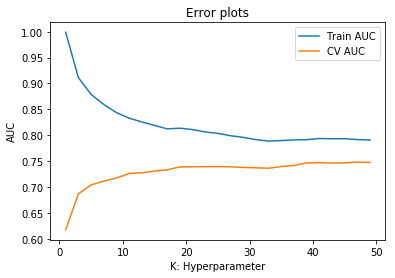

In [139]:
KNN_KDTree(X_train_bow_kd.todense(), Y_train_kd, X_cv_bow_kd.todense(), Y_cv_kd)

In [140]:
def KNN_Test_KDTree(X_train_vector, Y_train, X_test_vector, Y_test, bestK):
    best_k=bestK
    neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
    neigh.fit(X_train_vector, Y_train)

    train_FPR, train_TPR, thresholds = roc_curve(Y_train, neigh.predict_proba(X_train_vector)[:,1])
    test_FPR, test_TPR, thresholds = roc_curve(Y_test, neigh.predict_proba(X_test_vector)[:,1])
    
    test_auc = auc(test_FPR, test_TPR)
    plt.plot(train_FPR, train_TPR, label="Train AUC="+str(auc(train_FPR, train_TPR)))
    plt.plot(test_FPR, test_TPR, label="Test AUC="+str(test_auc))

    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    from sklearn.metrics import confusion_matrix
    print("Train confusion metric")
    print(confusion_matrix(Y_train, neigh.predict(X_train_vector)))
        
    print("Testing confusion metric")
    cm = confusion_matrix(Y_test, neigh.predict(X_test_vector))
    print(cm)
        
    # plot confusion matrix to describe the performance of classifier.
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show() 
    
    return test_auc

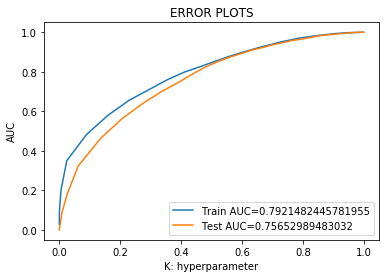

Train confusion metric
[[  678  2513]
 [  494 15915]]
Testing confusion metric
[[ 379 1542]
 [ 335 9744]]


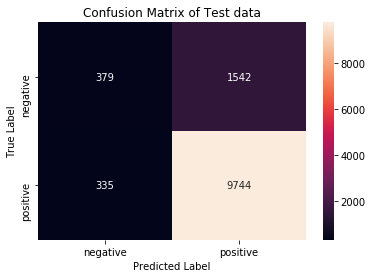

In [141]:
auc_kd_bow = KNN_Test_KDTree(X_train_bow_kd.todense(), Y_train_kd, X_test_bow_kd.todense(), Y_test_kd, bestK=40)

### [5.2.3] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

# 1: Hyper parameter Tuning

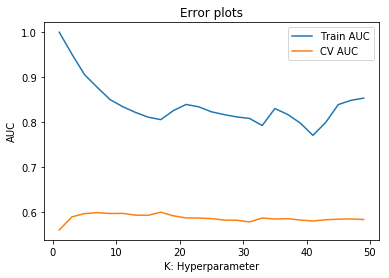

In [142]:
KNN_KDTree(X_train_tfidf_kd.todense(), Y_train_kd, X_cv_tfidf_kd.todense(), Y_cv_kd)

# 2: Testing with test data

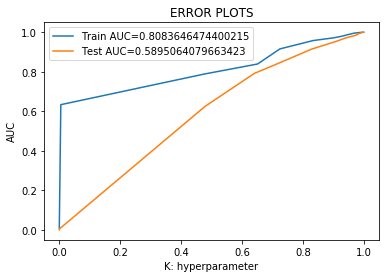

Train confusion metric
[[   12  3179]
 [    7 16402]]
Testing confusion metric
[[    6  1915]
 [    4 10075]]


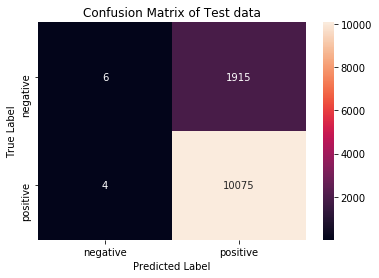

In [143]:
auc_kd_tfidf = KNN_Test_KDTree(X_train_tfidf_kd.todense(), Y_train_kd, X_test_tfidf_kd.todense(), Y_test_kd, bestK=30)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

# 1: Hyper parameter Tuning

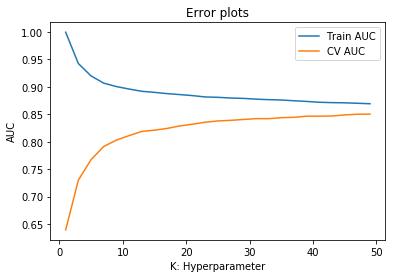

In [144]:
KNN_KDTree(sent_vectors_train_kd, Y_train_kd, sent_vectors_cv_kd, Y_cv_kd)

# 2: Testing with test data

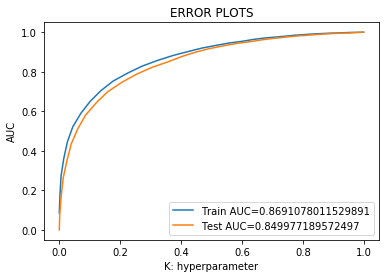

Train confusion metric
[[  626  2565]
 [  199 16210]]
Testing confusion metric
[[ 329 1592]
 [ 137 9942]]


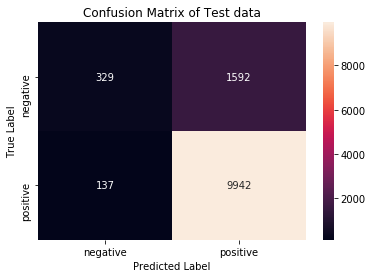

In [145]:
auc_kd_avgw2v = KNN_Test_KDTree(sent_vectors_train_kd, Y_train_kd, sent_vectors_test_kd, Y_test_kd, bestK=50)

### [5.2.4] Applying KNN kd-tree on TFIDF AVG,<font color='red'> SET 8</font>

# 1: Hyper parameter Tuning

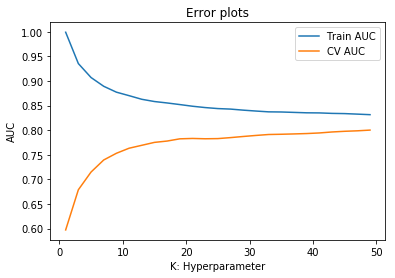

In [146]:
KNN_KDTree(tfidf_sent_vectors_train_kd, Y_train_kd, tfidf_sent_vectors_cv_kd, Y_cv_kd)

# 2: Testing with test data

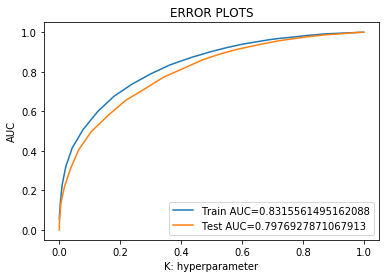

Train confusion metric
[[  293  2898]
 [   99 16310]]
Testing confusion metric
[[  136  1785]
 [   74 10005]]


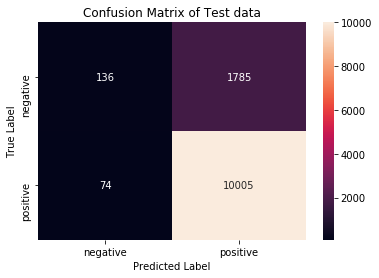

In [147]:
auc_kd_tfidfw2v = KNN_Test_KDTree(tfidf_sent_vectors_train_kd, Y_train_kd, tfidf_sent_vectors_test_kd, Y_test_kd, bestK=50)

# [6] Conclusions

In [150]:
# Please compare all your models using Prettytable library

models = pd.DataFrame({
'Vectorizer': ["BOW", "TFIDF", "W2V", "TFIDFW2V","BOW", "TFIDF", "W2V", "TFIDFW2V"], 
'Model' : ['brute', 'brute','brute','brute','kd_tree','kd_tree','kd_tree','kd_tree'],
'Hyper Parameter(K)': [40,30,50,40,40,30,50,50], 
'AUC': [auc_brute_bow,auc_brute_tfidf,auc_brute_avgw2v,auc_brute_tfidfw2v,auc_kd_bow,auc_kd_tfidf,auc_kd_avgw2v,auc_kd_tfidfw2v]}, 
columns = ["Vectorizer", "Model", "Hyper Parameter(K)", "AUC"])
print(models)

  Vectorizer    Model  Hyper Parameter(K)       AUC
0        BOW    brute                  40  0.671984
1      TFIDF    brute                  30  0.501122
2        W2V    brute                  50  0.878242
3   TFIDFW2V    brute                  40  0.847988
4        BOW  kd_tree                  40  0.756530
5      TFIDF  kd_tree                  30  0.589506
6        W2V  kd_tree                  50  0.849977
7   TFIDFW2V  kd_tree                  50  0.797693


* KNN with AVG W2V has the hightest AUC among other models using brute force & KD tree algorithm hence we can conclude KNN perform better with W2V however it's very close to TFIDF W2V AUC.
* KD-tree take lot of time for computation